In [2]:
using LinearAlgebra, FastGaussQuadrature, Distributions, StatsFuns, Plots, Interact

WebIO._IJuliaInit()

In [3]:
function integral(rule, n, f)
    xi, wi = rule(n)
    res = dot(wi, f.(xi))
        
    return res
end

function plot_integral(label, res...)
    plot(
        hcat(res...),
        label=label,
        title="integral value"
    )
end

# multi-dispatch
function converge(rule, n, func; tol=1e-6)
    res = [integral(rule, i, func) for i=1:n]
    d = diff(res)
    freeze = findfirst(x->abs(x)<=tol, d) + 1

    return d, freeze
end

function converge(rule, n, func::AbstractVector; tol=1e-6) 
    d, freeze = [
        reduce(hcat, i) 
        for i in zip(converge.(Ref(rule), Ref(n), func; tol=tol)...)   # question: why I cannot zip two vector
    ]
    
    return d, freeze
end

function converge(rule::AbstractVector, n, func::AbstractVector; tol=1e-6) 
    d, freeze = [
        reduce(hcat, i) 
        for i in zip(converge.(rule, Ref(n), func; tol=tol)...)
    ]
    
    return d, freeze
end;

# Homework: Gaussian Quadrature Integration

###### GH: Gauss-Hermite; GL: Gauss-Legendre; GLa: Gauss-Laguerre

For all the problems, you may obtain $\{\omega_i, \xi_i \}$ directly from Julia's `FastGaussQuadrature` packages. For instance, `xi, wi = gausslegendre(20)` would give $\{\omega_i, \xi_i \}$, $i=1,\ldots,20$, from the Gauss-Legendre rule.

### functional form

We denote $\Omega$ as the domain, and consider the intergration of $g(x)$. To apply the GQ rule, we need to decompose the problem in the following way

$$I = \int_\Omega g(x) dx = \int_\Omega f(x) p(x) dx \approx \sum_{i=1}^{n} \omega_i f(\xi_i)$$

###  weight and domain of each quadrature rule


|Quadrature Rule|   |Domain|                |$$ p(x) $$|                 |approximation|
|:-|                |:-|                    |:-:|                        | :-:| 
|Gauss-Legendre|    |$$[-1,1]$$|            |$$1$$|                      |$$\int_{-1}^1 f(x) \approx \sum_{i=1}^n \omega_i f(\xi_i)$$ | 
|Gauss-Chebyshev|   |$$[-1,1]$$|            |$$(1-x^2)^{-\frac{1}{2}}$$| |$$\int_{-1}^1 f(x)p(x) \approx \sum_{i=1}^n \omega_i f(\xi_i)$$ |
|Gauss-Hermite|     |$$(-\infty,\infty)$$|  |$$e^{-x^2} $$|              |$$\int_{-\infty}^\infty f(x)p(x) \approx \sum_{i=1}^n \omega_i f(\xi_i)$$ |
|Gauss-Laguerre|    |$$[0,\infty)$$|        |$$e^{-x}$$|                 |$$\int_0^\infty f(x)p(x) \approx \sum_{i=1}^n \omega_i f(\xi_i)$$ |

### integration by substitution 

>##### Change of Variables
>    
>If $x = \rho(t)$, then
>\begin{aligned}
 \int_a^b g(x) dx = \int_{\rho^{-1}(a)}^{\rho^{-1}(b)} g(\rho(t)) \rho'(t) dt,
\end{aligned}
>where $\rho'(t)$ is the Jacobian.

$$\mathbf{x\,\ domain}$$ | $$\mathbf{transformation}$$ | $$\mathbf{t\,\ domain}$$ | $$\mathbf{Jacobian}$$ 
 ---     |  ---    | ---      | --- 
$$[a, b]$$            | $$x = \frac{a+b}{2} + \frac{b-a}{2}t$$ | $$[-1,1]$$ | $$\frac{b-a}{2}$$
$$[-\infty, \infty]$$ | $$x = \frac{t}{1-t^2}$$        | $$[-1,1]$$ | $$\frac{t^2 + 1}{(t^2 -1)^2}$$
$$[a, \infty]$$       | $$x = a + \frac{1+t}{1-t}$$    | $$[-1,1]$$ | $$\frac{2}{(t-1)^2}$$
$$[-\infty, b]$$      | $$x = b - \frac{1-t}{1+t}$$    | $$[-1,1]$$ | $$\frac{2}{(t+1)^2}$$

### How to decompose $g(x)$ ?

We can construct $f(x)$ by timing $g(x)$ on $\frac{p(x)}{p(x)}$
$$I = \int_\Omega g(x) dx = \int_\Omega \frac{g(x)}{p(x)} p(x) dx \equiv  \int_\Omega f(x) p(x) dx $$
let $f(x) = \frac{g(x)}{p(x)}$

## 1. This problem asks you to adopt the Gauss-Hermite rule to an infinite integral where the weight function does not match.  The integration problem is:
  $$\begin{aligned}
   I = \int_{-\infty}^\infty g(x) d x =  \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx.
  \end{aligned}$$ 
 

- ##### Let's do this without using changes of variables. 
  - Transform $g(x)$ to $e^{-x^2}f(x)$ so that the Gauss-Hermite rule could be applied. Write down the re-formulated integration problem explicitly and write down $f(x)$ explicitly.
  - Write Julia code to integrate the function numerically.

Answer Key:

<blockquote>

Let $g(x) = \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2}$. In order to apply Gauss-Hermite rule, we need to assign $\exp(-x^2)$ as the weight function, which is then offset by multiplying $\exp(x^2)$ to $g(x)$. That is,
 
   $$\begin{aligned}
   I  = \int_{-\infty}^\infty g(x) dx  =   & \int_{-\infty}^\infty \exp(-x^2)\underbrace{\left[ \exp(x^2)g(x) \right]}_{\equiv f(x)} dx \\
      = &  \int_{-\infty}^\infty \exp(-x^2)f(x) dx
  \end{aligned}$$
  
Then we can apply the Gauss-Hermite rule: $\int_{-\infty}^\infty \exp(-x^2)f(x) dx \approx \sum_{i=1}^{n} \omega_i f(\xi_i)$ where $f(x) = \exp(x^2)g(x)$.
    
Essentially, we could multiply the _**inverse**_ of the weight function $\exp(x^2)$ to any function $g(x)$ to get $f(x) = \exp(x^2)g(x)$, and then apply the Gauss-Hermite rule to $f(x)$ to get the integration of $g(x)$ from $-\infty$ to $\infty$.
  
</blockquote>   

- 吳天冷
- With using changes of variables: \
Let $z^2 = \frac{1}{3}x^2$, so $x^2 = 3z^2$, $x = \sqrt{3}z$. Then the re-formulated integration problem will be:
$$\begin{aligned}
      \int_{-\infty}^\infty \sqrt{3}e^{-z^2}\sqrt{1 + 3z^2} dz.
  \end{aligned}$$ 
Note that the Jacobian is $\sqrt{3}$, and $f(z) = \sqrt{3(1+3z^2)} = \sqrt{3+9z^2}$. We can also see that the domain does not change.

integral(gausshermite, 30, f1) = 4.563813008885369
integral(gausshermite, 30, f2) = 4.563849797167212


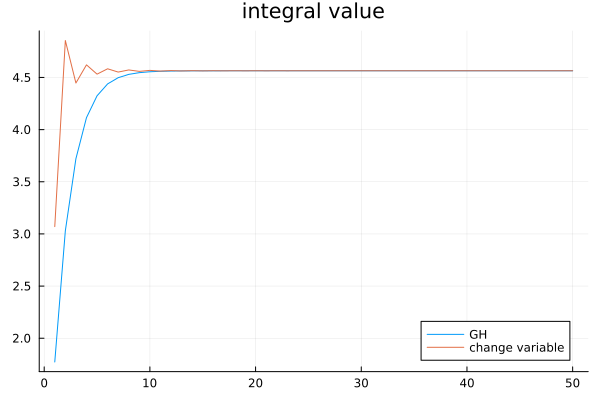

In [21]:
g = x -> exp(-x^2/3) * sqrt(1+x^2)
f1 = x -> g(x) * exp(x^2)
f2 = x -> sqrt(3+9x^2)

@show integral(gausshermite, 30, f1)
@show integral(gausshermite, 30, f2)
# plot([g f1 f2], labels=["g(x)" "GHrule" "change variable"], layout=(3, 1)) |> display
    
plot_integral(
    ["GH" "change variable"],
    [integral(gausshermite, i, f1) for i=1:50],
    [integral(gausshermite, i, f2) for i=1:50]
)

In [22]:
# 劉浩揚: plot difference, 潘家栩: dash line
@manipulate for tol in (1e-4, 1e-6, 1e-8)
    d, freeze = converge(gausshermite, 200, [f1, f2]; tol=tol)

    plot(
        d, labels=["GH" "change variable"], xlim=[0, maximum(freeze)+5], 
       title="converge status", linewidth=2
    )
    vline!(
        freeze, 
        labels=["GH n:$(freeze[1, 1])" "change variable n:$(freeze[1, 2])"], 
        linestyle=:dash
    )
    
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["tol"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol, Any}(:attributes => ("data-bind" => "foreach : options_js"), :className => "buttons has-addons is-centered"))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedDict[OrderedDict{String, Any}("key" => "0.0001", "val" => 1, "id" => "idxvOr1ALK"), OrderedDict{String, Any}("key" => "1.0e-6", "val" => 2, "id" => "idSVkHkLhH"), OrderedDict{String, Any}("key" => "1.0e-8", "val" => 3, "id" => "id7beGaHF8")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000007326ba30, Task (runnable) @0x000000007326ba30), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n

## 2. Write a Julia function with the following specifications.
  - It calculates $E[g(y)]$ for any arbitrary $g(y)$ where $y \sim N(\mu, \sigma^2)$.
  - User's inputs include $g(y)$, $\mu$, $\sigma^2$, and $n$.
  - You may obtain $\{\omega_i, \xi_i\}$ directly from Julia's package.
  - If $g(y) = 1 + 3y + y^2$, $y \sim N(1,2)$, and $n=30$, the interface could be like `myInteg(1 + 3y + y^2, mean=1, variance=2, n=30)`, or, `myInteg(g, mean=1, variance=2, n=30)`.
  - Hint: You may define the probability density function of $y$ using the `Distributions` package and then `pdf(Normal(mean, std.dev.),x)`.

##### support：函數自變數所有取值的不為0的集合
##### domain：函數自變數所有可取值的集合

##### In Example (change variable)

Let's see an example. Suppose we have a function $g(y)$ where $y \sim N(\mu, \sigma^2)$ is a random variable. For example, $g(y)$ may be a profit function where $y$ is a random shock. What is $E[g(y)]$, the expected value of $g(y)$? We know, by definition,

\begin{aligned}
E[g(y)] = \int_{-\infty}^{\infty} g(y) \frac{1}{\sigma\sqrt{2 \pi}} \exp\left( - \frac{1}{2} 
         \left( \frac{y-\mu}{\sigma} \right)^2  \right) dy.
\end{aligned}

The problem does not fit exactly the Hermite weighting function. We will use the change of variable again to transform the problem.

The transformation we use here is

\begin{aligned}
  t = \frac{y-\mu}{\sqrt{2}\sigma},\quad\mbox{or,}\quad y = \rho(t)= \sqrt{2}\sigma t + \mu.
\end{aligned}

Note that the transformation rule leaves $t=-\infty$ when $y=-\infty$ and $t=\infty$ when $y=\infty$, and so the domain is still at $[-\infty, \infty]$. Here the Jacobian is $\rho'(t) = \sqrt{2}\sigma$. Then,

\begin{aligned}
 E[g(y)] & = \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}\sigma} g(y) \exp\left( -\frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2 \right)dy \\
    & = \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}\sigma} g(\sqrt{2}\sigma t + \mu) \exp(-t^2)\sqrt{2}\sigma dt \\
    & = \int_{-\infty}^\infty  \exp(-t^2) \frac{1}{\sqrt{\pi}}g(\sqrt{2}\sigma t +\mu) dt.
\end{aligned}

The formulation now fits the Gauss-Hermite form with $\exp(-t^2)$ being the weight function. We can then go ahead to obtain $\{\omega_i, \xi_i \}$ from the Gauss-Hermite rule, and 

\begin{aligned}
E[g(y)] \approx \sum_{i=1}^{n} \omega_i \Big[\frac{1}{\sqrt{\pi}} g(\sqrt{2}\sigma \xi_i + \mu)\Big].
\end{aligned}

integral(gausshermite, 30, f1) = 6.999792968988663
integral(gausshermite, 30, f2) = 6.999999999999995


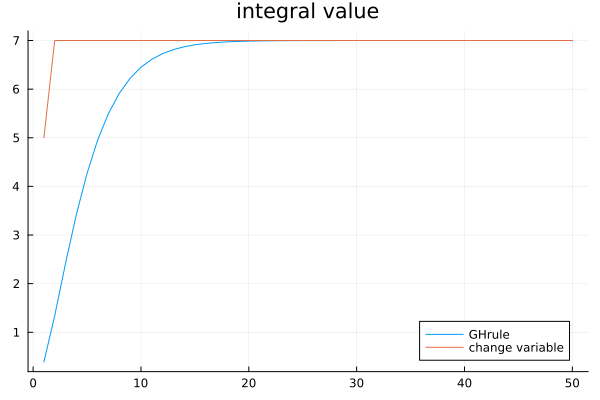

In [23]:
μ, σ² = 1, 2
g = x -> 1 + 3x + x^2
_g = x -> g(x) * normpdf(μ, sqrt(σ²), x)


f1 = x -> _g(x) * exp(x^2)
f2 = x ->  (1/sqrt(π)) * g(sqrt(2*σ²)*x + μ)  # 于庭歡

@show integral(gausshermite, 30, f1)
@show integral(gausshermite, 30, f2);
# plot([_g f1 f2], labels=["_g" "f1" "f2"], layout=(3, 1)) |> display

plot_integral(
    ["GHrule" "change variable"],
    [integral(gausshermite, i, f1) for i=1:50],
    [integral(gausshermite, i, f2) for i=1:50]
)

In [24]:
@manipulate for tol in (1e-4, 1e-6, 1e-8)
    d, freeze = converge(gausshermite, 200, [f1, f2]; tol=tol)

    plot(
        d, labels=["GHrule" "change variable"], xlim=[0, maximum(freeze)+5], 
        title="converge status", linewidth=2
    )
    vline!(
        freeze, labels=["GHrule n:$(freeze[1, 1])" "change variable n:$(freeze[1, 2])"], 
        linestyle=:dash
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["tol"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol, Any}(:attributes => ("data-bind" => "foreach : options_js"), :className => "buttons has-addons is-centered"))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedDict[OrderedDict{String, Any}("key" => "0.0001", "val" => 1, "id" => "idLPlZCJ0w"), OrderedDict{String, Any}("key" => "1.0e-6", "val" => 2, "id" => "ido3eBOjYP"), OrderedDict{String, Any}("key" => "1.0e-8", "val" => 3, "id" => "idIqnsGgJP")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000072dcfc20, Task (runnable) @0x0000000072dcfc20), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n

## 3. It is generally true that proper integrals (i.e., with finite domains) are numerically easier to deal with. But what if a problem is naturally a GH type with an infinite domain and we transform it to a GL problem with a finite domain? Is the GL rule better in this scenario? Let's find out the answer. Consider the following integration problem which is often encountered in econometric analysis. 

$$\begin{aligned}
      I = \int_{-\infty}^\infty \Phi\left(\frac{x-a}{b}\right)\phi(x) dx,
\end{aligned}$$

where $X\sim N(0,1)$ is a standard normal random variable, $\phi(z)$ is the density function (PDF) of a random variable $z$, and $\Phi(z)$ is the CDF of $z$.
   - ##### Write a Julia function that uses the GH rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Transform this problem to the GL type. What is the transformation rule and what is the Jacobian? Type the equations and show your work.
   - ##### Write a Julia function that uses the GL rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions. Which one converges more quickly (smaller $n$)? You may pick values of $a$ and $b$ to do the comparison. You may draw graphs to compare the results.
   - ##### Based on your results, is the GL rule always the most efficient?

Anser Key:
<blockquote>
    
- Use the GH rule:
    
    Let $g(x) =  \Phi\left(\frac{x-a}{b}\right)\phi(x)$.
 
   $$\begin{aligned}
     I =\int_{-\infty}^\infty g(x) dx  
       = & \int_{-\infty}^{\infty} \exp(-x^2) \exp(x^2)g(x) dx \\
       = & \int_{-\infty}^{\infty} \exp(-x^2) f(x) dx,
 \end{aligned}$$
  
 where $f(x) = \exp(x^2)g(x)$. Note, in this case we don't need to do variable transformation nor the Jacobian.
 
    
- Use the GL rule:
    
    Let $x = \frac{t}{1-t^2}$  so that the domain of the integral over variable $t$ is $\left[-1,1\right]$. The Jacobian is $(1+t^2)/(1-t^2)^2$.
 
  $$\begin{aligned}
 I =\int_{-\infty}^\infty g(x) dx 
   =\int_{-1}^1 g\left(\frac{t}{1-t^2}\right)\frac{1+t^2}{(1-t^2)^2} dt 
   \equiv \int_{-1}^1 f(t) dt.
 \end{aligned}$$
    
</blockquote>    

integral(gausshermite, 30, f_GH) = 0.185546684761347
integral(gausslegendre, 30, f_GL) = 0.18556014292672407


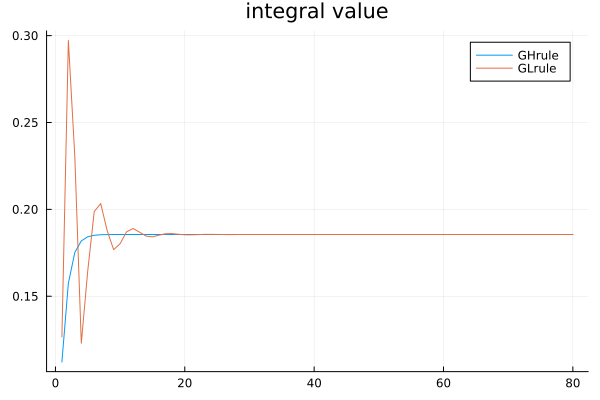

In [5]:
# wrong: g(x)= cdf(Normal(-a/b,sqrt(1/b^2)), x) * pdf(Normal(0,1), x)

a, b = 2, 2
g = x -> cdf(Normal(), (x-a)/b) * pdf(Normal(), x)

# gauss hermite
inverse_weight(x) = exp(x^2)
f_GH = x -> inverse_weight(x) * g(x)
@show integral(gausshermite, 30, f_GH)

# gauss legendre
tran_rule(t) = t/(1-t^2)
jacobian_GL = t -> (1+t^2)/((1-t^2)^2)
f_GL = t -> g(tran_rule(t)) * jacobian_GL(t)
@show integral(gausslegendre, 30, f_GL)

plot_integral(
    ["GHrule" "GLrule"],
    [integral(gausshermite, i, f_GH) for i=1:80],
    [integral(gausslegendre, i, f_GL) for i=1:80]
)

In [26]:
@manipulate for tol in (1e-4, 1e-6, 1e-8)
    d, freeze = converge([gausshermite, gausslegendre], 200, [f_GH, f_GL]; tol=tol)

    plot(
        d, labels=["GHrule" "GLrule"], xlim=[0, maximum(freeze)+5], 
        title="converge status", linewidth=2
    )
    vline!(
        freeze, labels=["GHrule n:$(freeze[1, 1])" "GLrule n:$(freeze[1, 2])"], 
        linestyle=:dash
    )
    
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["tol"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol, Any}(:attributes => ("data-bind" => "foreach : options_js"), :className => "buttons has-addons is-centered"))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedDict[OrderedDict{String, Any}("key" => "0.0001", "val" => 1, "id" => "idEiwQoGdM"), OrderedDict{String, Any}("key" => "1.0e-6", "val" => 2, "id" => "idi2JuHkes"), OrderedDict{String, Any}("key" => "1.0e-8", "val" => 3, "id" => "id2uOhXkX3")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000007941aab0, Task (runnable) @0x000000007941aab0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n

- 申大昀

\begin{aligned}
  t = \frac{x-\mu}{\sqrt{2}\sigma} = \frac{x}{\sqrt{2}},\quad\mbox{or,}\quad x = \sqrt{2}t .
\end{aligned}

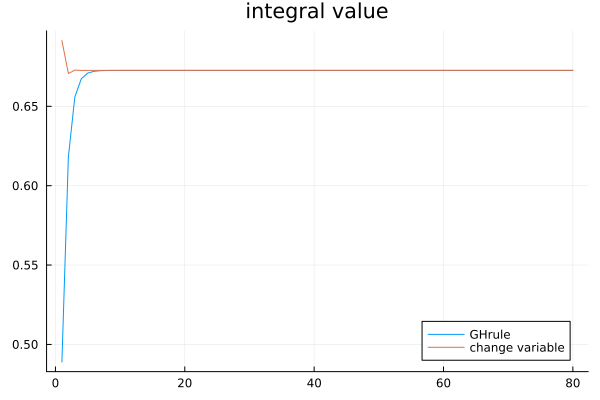

In [27]:
f2 = t -> cdf(Normal(0,1),(sqrt(2)*t-a)/b) * (1/sqrt(π))

# plot([g f_GH f2], labels=["g" "f_GH" "f2"], layout=(3, 1)) |> display

plot_integral(
    ["GHrule" "change variable"],
    [integral(gausshermite, i, f_GH) for i=1:80],
    [integral(gausshermite, i, f2) for i=1:80]
)

In [28]:
@manipulate for tol in (1e-4, 1e-6, 1e-8)
    d, freeze = converge(gausshermite, 200, [f_GH, f2]; tol=tol)

    plot(
        d, labels=["GHrule" "change variable"], xlim=[0, maximum(freeze)+5], 
        title="converge status", linewidth=2
    )
    vline!(
        freeze, labels=["GHrule n:$(freeze[1, 1])" "change variabel n:$(freeze[1, 2])"], 
        linestyle=:dash
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["tol"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol, Any}(:attributes => ("data-bind" => "foreach : options_js"), :className => "buttons has-addons is-centered"))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedDict[OrderedDict{String, Any}("key" => "0.0001", "val" => 1, "id" => "idBpPV0igT"), OrderedDict{String, Any}("key" => "1.0e-6", "val" => 2, "id" => "idTXJ2Tl7u"), OrderedDict{String, Any}("key" => "1.0e-8", "val" => 3, "id" => "id53zAB3Ig")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000000e91fe10, Task (runnable) @0x000000000e91fe10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n

## 4. This problem asks you to consider an integration problem where it can be transformed to different types to use different Gaussian quadrature rules. Which one is the best? The integration problem is:

 $$\begin{aligned}
 \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx,
 \end{aligned}$$

where $a$ is finite but not necessarily 0. This problem has some characteristics of the GLa and GH types: It has an exponential function, and by mapping $a$ to $-1$, $0$ or $-\infty$ via change of variables, the domain would be of the GL, GLa and GH types, respectively. You are asked to perform the approximation using rules of each of the types and compare the performance. In the code, make $a$ a parameter that we can assign a value to it.

 - ##### Write Julia code that uses the GL rule to approximate the integral. 
 - ##### Write Julia code that uses the GLa rule to approximate the integral. 
 - ##### Write Julia code that uses the GH rule to approximate the integral. 
 - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions; drawing a graph will be useful. You may pick a value for $a$ in the comparison. 
 - ##### According to your result above, which rule converges more quickly (smaller $n$)? What is the intuition behind the result?

Answer Key:    
<blockquote>
    
- the GL rule:
    
    Let $x = a+\frac{1+t}{1-t}$  so that the domain of the integral over variable $t$ is $\left[-1,1\right]$. The Jacobian is $2/(t-1)^2$.
 
  $$\begin{aligned}
     \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx  
  = & \int_{a}^\infty g(x) dx \\
  = & \int_{-1}^1 g\left(a+\frac{1+t}{1-t}\right)\frac{2}{(t-1)^2} dt\\
  = & \int_{-1}^1 f(t) dt,
 \end{aligned}$$   

    where $f(t)=g\left(a+\frac{1+t}{1-t}\right)\frac{2}{(t-1)^2}$.
   
- the GLa rule:
    
    Let $x = a+t$  so that the domain of the integral over variable $t$ is $\left[0,\infty\right]$. The Jacobian is 1.
 
  $$\begin{aligned}
      \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx  
  = & \int_{a}^\infty g(x) dx \\ 
  = &  \int_{0}^{\infty} \exp(-t)g(a+t)\exp(t) dt \\
 \equiv & \int_{0}^{\infty} \exp(-t)f(t) dt,
  \end{aligned}$$

    where $f(t)=g(a+t)\exp(t)$.
 
    
- the GH rule:
    
    Let $x = a + \exp(t)$ so that the domain of the integral over variable $t$ is $\left[-\infty,\infty\right]$. The Jacobian is $\exp(t)$.
 
   $$\begin{aligned}
 \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx
  = & \int_{a}^\infty g(x) dx \\ 
  = & \int_{-\infty}^{\infty} g(a+\exp(t))\exp(t) dt \\
  = & \int_{-\infty}^{\infty} \exp(-t^2)\exp(t^2)g(a+\exp(t))\exp(t) dt, \\
  = & \int_{-\infty}^{\infty} \exp(-t^2)f(t) dt,
 \end{aligned}$$
    
    where $f(t)=\exp(t^2)g(a+\exp(t))\exp(t)$.

</blockquote>

In [29]:
a = -0.5  # may be changed at will
n = 100
g = x -> exp(-x^2/100) * (1+x^2)        # original integrand

# Gauss-Legendre
tran_GL(t) = a+(1+t)/(1-t)
jacobian_GL = t -> 2/((1-t)^2)
f_GL = t -> g(tran_GL(t)) * jacobian_GL(t)    # transformed integrand
@show integral(gausslegendre, n, f_GL)

# Gauss-Laguerre
tran_GLa(t) = t+a  # jacobian=1
inverse_weight_GLa(t) = exp(t)
f_GLa = t -> g(tran_GLa(t)) * inverse_weight_GLa(t)
@show integral(gausslaguerre, n, f_GLa)

# Gauss-Hermite
tran_GH(t)     = a + exp(t)
jacobian_GH(t) = exp(t)
inverse_GH(t)  = exp(t^2)
f_GH = t-> g(tran_GH(t)) * jacobian_GH(t) * inverse_GH(t)
@show integral(gausshermite, n, f_GH);

integral(gausslegendre, n, f_GL) = 452.51692140195075
integral(gausslaguerre, n, f_GLa) = 452.5169198489851
integral(gausshermite, n, f_GH) = 452.51691844017523


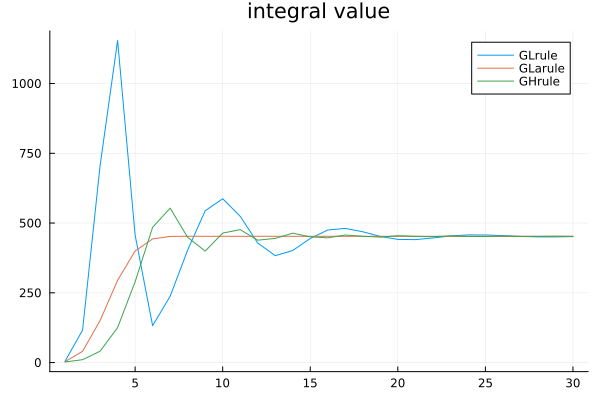

In [30]:
# plot([g f_GL f_GLa f_GH], labels=["g" "f_GL" "f_GLa" "f_GH"], layout=(4, 1)) |> display

plot_integral(
    ["GLrule" "GLarule" "GHrule"],
    [integral(gausslegendre, i, f_GL) for i=1:30],
    [integral(gausslaguerre, i, f_GLa) for i=1:30],
    [integral(gausshermite, i, f_GH) for i=1:30]
)

In [31]:
@manipulate for tol in (1e-4, 1e-6, 1e-8)
    d, freeze = converge(
        [gausslegendre, gausslaguerre, gausshermite], 
        150, 
        [f_GL, f_GLa, f_GH]; 
        tol=tol
    )

    plot(
        d, 
        labels=["GL" "GLa" "GH"], xlim=[0, maximum(freeze)+5], 
        title="converge status", linewidth=2
    )
    vline!(
        freeze, labels=["GL n:$(freeze[1, 1])" "GLa n:$(freeze[1, 2])" "GH n:$(freeze[1, 3])"], 
        linestyle=:dash
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["tol"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol, Any}(:attributes => ("data-bind" => "foreach : options_js"), :className => "buttons has-addons is-centered"))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedDict[OrderedDict{String, Any}("key" => "0.0001", "val" => 1, "id" => "idlWVxZbyJ"), OrderedDict{String, Any}("key" => "1.0e-6", "val" => 2, "id" => "idWAlwsyax"), OrderedDict{String, Any}("key" => "1.0e-8", "val" => 3, "id" => "idtwgyvljh")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\pupss\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\InteractBase\\Qhvxg\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\pupss\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000007326aca0, Task (runnable) @0x000000007326aca0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n